# Mapping in Python

Much of this material was originally written by our friend [Kim Ruhl](http://kimjruhl.com/). We
are grateful for his willingness to share.

**Prerequisites**

- [matplotlib Introduction](pandas/matplotlib.ipynb)  
- [Visualization Rules](visualization_rules.ipynb)  


**Outcomes**

- Use geopandas to create maps  

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline

## Mapping in Python

In this lecture, we will use a new package, `geopandas`, to create maps. Maps are really quite
complicated… We are trying to project a spherical surface onto a flat figure, which is an
inherently complicated endeavor. Luckily, `geopandas` will do most of the heavy lifting for us

Let’s start with a DataFrame that has the latitude and longitude of various South American cities.
Our goal is to turn them into something we can plot – In this case, a `GeoDataFrame`

In [2]:
df = pd.DataFrame({
    'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
    'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
    'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
    'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]
})

In order to map the cities, we need tuples of coordinates. We will generate these by zipping the
latitude and longitude together and storing them in a new column named `Coordinates`

In [3]:
df["Coordinates"] = list(zip(df.Longitude, df.Latitude))
df.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,"(-58.66, -34.58)"
1,Brasilia,Brazil,-15.78,-47.91,"(-47.91, -15.78)"
2,Santiago,Chile,-33.45,-70.66,"(-70.66, -33.45)"
3,Bogota,Colombia,4.60,-74.08,"(-74.08, 4.6)"
4,Caracas,Venezuela,10.48,-66.86,"(-66.86, 10.48)"


Our next step is to turn the tuple into a `Shapely` `Point` object. We will do this by applying
Shapely’s `Point` method to the `Coordinates` column

In [4]:
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66 -34.58)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91 -15.78)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66 -33.45)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08 4.6)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86 10.48)


Finally, we will convert our DataFrame into a GeoDataFrame by simply calling the
geopandas.DataFrame method

The benefit of this is that a GeoDataFrame is a data structure with much of the convenience of a
normal DataFrame but that also understands how to plot maps. The important part in the code below is
that we specify the column that contains the geometry data. See this excerpt from the docs

> The most important property of a GeoDataFrame is that it always has one GeoSeries column that
holds a special status. This GeoSeries is referred to as the GeoDataFrame’s “geometry”. When a
spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this
commands will always act on the “geometry” column.

In [5]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66 -34.58)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91 -15.78)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66 -33.45)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08 4.6)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86 10.48)


In [6]:
# Doesn't look different than a vanilla DataFrame...let's make sure we have what we want.
print('gdf is of type:', type(gdf))

# And how can we tell which column is the geometry column?
print('\nThe geometry column is:', gdf.geometry.name)

gdf is of type: <class 'geopandas.geodataframe.GeoDataFrame'>

The geometry column is: Coordinates


### Plotting a map

Great. Now we have our points in the GeoDataFrame. Let’s plot the locations on a map. This will
require 3 steps

1. Get the map  
1. Plot the map  
1. Plot the points (our cities) on the map  

#### 1. Get the map

An organization called [Natural Earth](https://www.naturalearthdata.com/) compiled the map data
that we use here. The file provides the outlines of countries over which we will plot the locations
of the cities in our GeoDataFrame. Luckily, `geopandas` already comes with this data bundled into
it, so we don’t have to hunt it down!

In [7]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


`world` is a GeoDataFrame with the following columns

- `pop_est`: Contains a population estimate for the country  
- `continent`: Specifies which continent the country is in  
- `name`: The country’s name  
- `iso_a3`: The country’s 3 letter abbreviation  
- `gdp_md_est`: An estimate of country’s GDP  
- `geometry`: A `POLYGON` for each country – We will learn more about these soon  

In [8]:
world.geometry.name

'geometry'

Notice that the geometry for this GeoDataFrame is stored in the `geometry` column

**A quick note about polygons**

Instead of points (as in the case of our cities), the geometry objects are now polygons. A polygon
is likely what you already think it is – It’s a collection of ordered points that are connected by
straight lines. The smaller the distance between points, the more readily the polygon can
approximate non-linear shapes

Let’s see an example of a polygon

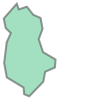

In [9]:
world.loc[2, 'geometry']

Notice, it displayed the country of Albania.

In [10]:
# Returns two arrays that hold the x and y coordinates of the points that define the polygon's exterior.
x, y = world.loc[2,'geometry'].exterior.coords.xy

# How many points?
print('Points in the exterior of Albania:', len(x))

Points in the exterior of Albania: 22


Let’s see another

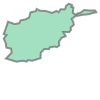

In [11]:
world.loc[0, 'geometry']

In [12]:
# Returns two arrays that hold the x and y coordinates of the points that define the polygon's exterior.
x, y = world.loc[0, 'geometry'].exterior.coords.xy

# How many points?
print('Points in the exterior of Afghanistan:', len(x))

Points in the exterior of Afghanistan: 69


Notice that now we’ve displayed Afghanistan. This is a more complex shape than Albania and so
required more points

#### 2. Plotting the map

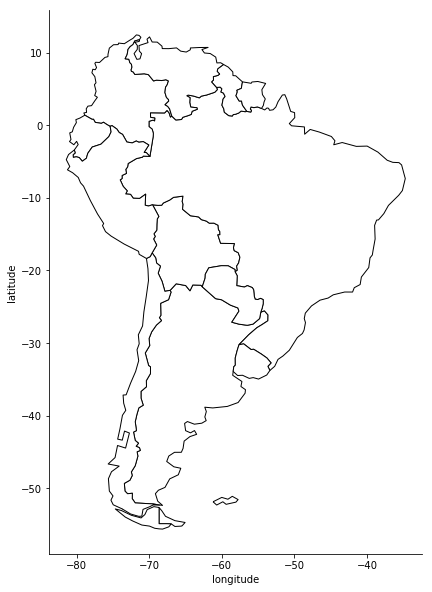

In [13]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("continent == 'South America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Creating this map may have been easier than you expected! This is because behind the scenes, a lot
of heavy lifting is going on. There are classes (and even majors!) that focus on the theory and
thought that goes into creating maps, but, for now, we are happy to rely on the work done by the
experts behind `geopandas` and the related libraries

#### 3. Plot the cities

In the code below, we run the same commands as before to plot the counties in South America, but
, now, we also plot the data in `gdf` which had the location of various cities in South America

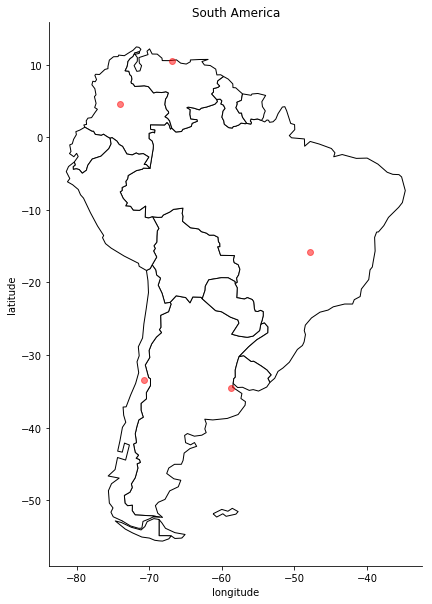

In [14]:
# Step 3: plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("continent == 'South America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same sytax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('South America')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

**Adding labels to points**

Finally, we might want to consider annotating the cities so we know which cities they are

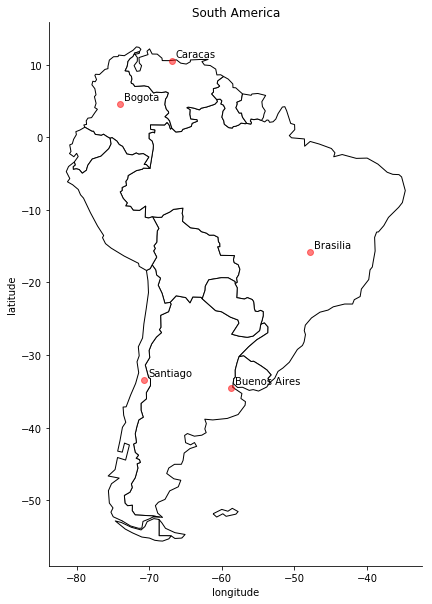

In [15]:
# Step 3: plot the cities onto the map
# We mostly use the code from before --- we still want the country borders ploted --- and we add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well, South America.
world.query("continent == 'South America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same sytax, but we are plotting from a different GeoDataFrame. I want the
# cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('South America')

# Kill the spines...
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# ...or get rid of all the axis. Is it important to know the lat and long?
# plt.axis('off')


# Label the cities
for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['City']):
    gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

plt.show()

## Case Study: Voting in Wisconsin

In the example that follows, we will demonstrate how each county in Wisconsin voted during the 2016
Presidential Election. Along the way we will learn a couple of valuable lessons:

1. Where to find shape files for US states and counties  
1. Practice matching census style data to shape files  

### Find and plot state border

Our first step will be to find the border for the state of interest. This can be found on the US
Census’s website [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html)

You can download the `cb_2016_us_state_5m.zip` by hand, or simply allow `geopandas` to extract
the relevant information from the zip file online

In [16]:
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
state_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"(POLYGON ((-88.04374299999999 30.517423, -88.0..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1477946266785,245390495931,"(POLYGON ((-133.655819 55.625617, -133.624921 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268429343790,1175112870,"POLYGON ((-109.060253 38.599328, -109.059541 3..."
4,09,01779780,0400000US09,09,CT,Connecticut,00,12542638347,1815476291,"POLYGON ((-73.72777499999999 41.100696, -73.69..."


In [17]:
print(state_df.columns)

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


We have various columns, but, most importantly, we can find the right geometry by filtering on name

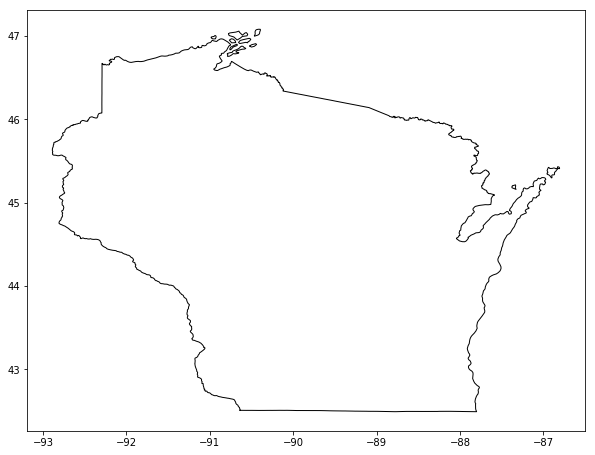

In [18]:
fig, gax = plt.subplots(figsize=(10, 10))
state_df.query("NAME == 'Wisconsin'").plot(ax=gax, edgecolor="black", color="white")
plt.show()

### Find and plot county borders

Next we will add the county borders to our map. The county shape files (for the entire US) can be
found on the Census site [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html).
Once again we will use the 5m resolution

In [19]:
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")
county_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,04,015,00025445,0500000US04015,04015,Mohave,06,34475567011,387344307,"POLYGON ((-114.755618 36.087166, -114.753638 3..."
1,12,035,00308547,0500000US12035,12035,Flagler,06,1257365642,221047161,"POLYGON ((-81.52365999999999 29.622432, -81.32..."
2,20,129,00485135,0500000US20129,20129,Morton,06,1889993251,507796,"POLYGON ((-102.041952 37.024742, -102.04195 37..."
3,28,093,00695770,0500000US28093,28093,Marshall,06,1828989833,9195190,"POLYGON ((-89.7243244282036 34.9952117286505, ..."
4,29,510,00767557,0500000US29510,29510,St. Louis,25,160458044,10670040,"POLYGON ((-90.318212 38.600017, -90.301828 38...."


In [20]:
print(county_df.columns)

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


Wisconsin’s FIP code is 55 so we will make sure that we only keep those counties

In [21]:
county_df = county_df.query("STATEFP == '55'")

Now we can plot all of the counties in Wisconsin

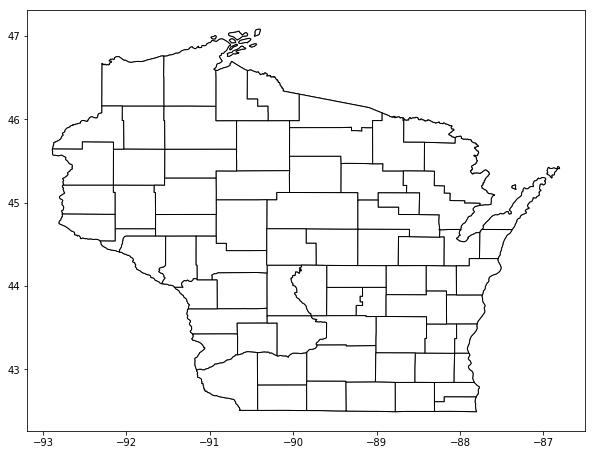

In [22]:
fig, gax = plt.subplots(figsize=(10, 10))

state_df.query("NAME == 'Wisconsin'").plot(ax=gax, edgecolor="black", color="white")
county_df.plot(ax=gax, edgecolor="black", color="white")

plt.show()

### Get vote data

The final step is to get the vote data. It can be found online on
[this site](https://elections.wi.gov/elections-voting/results/2016/fall-general). Our friend Kim
says,

> Go ahead and open up the file. It’s a mess! I saved a cleaned up version of the file to
`results.csv` which we can use to save the hassle with cleaning the data. For fun, you should
load the raw data and try beating it into shape. That’s what you normally would have to do…
and it’s fun.


The only thing we would add to what he said is that such an exercise is also “good for you” (in a
similar way as vegetables being good for you)

But, for the example in class, we’ll simply start with his cleaned data

In [23]:
results = pd.read_csv("http://sscc.wisc.edu/~ruhl2/f18_econ_690/results.csv", thousands=",")
results.head()

,county,total,trump,clinton
0,ADAMS,10130,5966,3745
1,ASHLAND,8032,3303,4226
2,BARRON,22671,13614,7889
3,BAYFIELD,9612,4124,4953
4,BROWN,129011,67210,53382


Notice that this is NOT a GeoDataFrame… It has no geographical information, but what it does have
are the names of each county. We will be able to use this to match to the counties from
`county_df`

First, there is a little bit of cleaning up to finish.

In [24]:
results["county"] = results["county"].str.title()
results["county"] = results["county"].str.strip()
county_df["NAME"] = county_df["NAME"].str.strip()

Then we can merge the election results with the county data

In [25]:
res_w_states = county_df.merge(results, left_on="NAME", right_on="county", how="inner")

Next we’ll create a new variable called `trump_share` which will denote what percent of the votes
Donald Trump won during the election

In [26]:
res_w_states["trump_share"] = res_w_states["trump"] / res_w_states["total"]
res_w_states.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,county,total,trump,clinton,trump_share
0,55,035,01581077,0500000US55035,55035,Eau Claire,06,1652211310,18848512,"POLYGON ((-91.65045499999999 44.855951, -90.92...",Eau Claire,55025,23331,27340,0.424007
1,55,113,01581116,0500000US55113,55113,Sawyer,06,3256410077,240690443,"POLYGON ((-91.551282 46.157045, -91.2383809999...",Sawyer,9137,5185,3503,0.567473
2,55,101,01581111,0500000US55101,55101,Racine,06,861267826,1190381762,"POLYGON ((-88.30638399999999 42.842095, -88.06...",Racine,94302,46681,42641,0.495016
3,55,097,01581109,0500000US55097,55097,Portage,06,2074100548,56938133,"POLYGON ((-89.844931 44.684945, -89.345917 44....",Portage,38589,17305,18529,0.448444
4,55,135,01581127,0500000US55135,55135,Waupaca,06,1936525696,45266211,"POLYGON ((-89.22374499999999 44.681365, -88.60...",Waupaca,26095,16209,8451,0.621153


Finally we can create our map

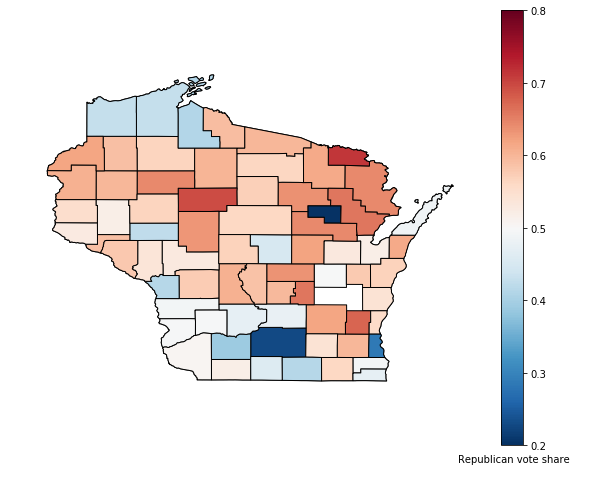

In [27]:
fig, gax = plt.subplots(figsize = (10,8))

# Plot the state
state_df[state_df['NAME'] == 'Wisconsin'].plot(ax = gax, edgecolor='black',color='white')

# Plot the counties and pass 'trump_share' as the data to color
res_w_states.plot(
    ax=gax, edgecolor='black', column='trump_share', legend=True, cmap='RdBu_r',
    vmin=0.2, vmax=0.8
)

# Add some text to let people know what we are plotting
gax.annotate('Republican vote share',xy=(0.76, 0.06),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

What do you see from this map?

How many counties did Trump win? How many did Clinton win?

In [28]:
res_w_states.eval("trump > clinton").sum()

59

In [29]:
res_w_states.eval("clinton > trump").sum()

12

Who had more votes? Do you think a comparison in counties won or votes won is more reasonable? Why
do you think they diverge?

In [30]:
res_w_states["trump"].sum()

1374262

In [31]:
res_w_states["clinton"].sum()

1365149

What story could you tell about this divergence?

# Interactivity

There are multiple python libraries for creating interactive figures. Here we will see an example using `bokeh`. In the next lecture we will see an example with `folium`.

In [63]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
output_notebook()
import json

#Convert data to geojson for bokeh
wi_geojson=GeoJSONDataSource(geojson=res_w_states.to_json())


Loading BokehJS ...

In [65]:
wi_geojson.properties_with_values()
color_mapper = LinearColorMapper(palette = brewer['RdBu'][10], low = 0, high = 1)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('County','@county'),('% Trump', '@trump_share')])
p = figure(title="Wisconsin Voting", tools=[hover])
p.patches("xs","ys",source=wi_geojson,
          fill_color = {'field' :'trump_share', 'transform' : color_mapper}
          )
p.add_layout(color_bar, 'below')
show(p)
